## Logistic & Linear regression in Python
### Logistic and Linear Regression using Seaborn, Statsmodels, and Scikit-learn

Performing logistic regression in Python using:
- regplot function from the seaborn library
- GLM (Generalized Linear Models) with Binomial family and Logit (default) link from the Statsmodels library
- Logit function from the Statsmodels library
- LogisticRegression from the scikit-learn library

Bootstrap method application is demonstrated for the purpose of estimating confidence intervals on logistic regression coefficients and predictions.

Performing linear regression in Python using:
- regplot function from the seaborn library
- OLS (Ordinary Least Squares) from the Statsmodels library
- LinearRegression from the scikit-learn library

Bootstrap method application is demonstrated for the purpose of estimating confidence intervals on linear regression coefficients and predictions.

In [1]:
from __future__ import print_function

import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


sns.set(style='darkgrid', font_scale=1.2)

%matplotlib inline

### Load some data for the demonstration purposes

In [2]:
# load "tips" dataset from the seaborn library
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
# Create a categorical variable for the regression analysis
tips["big_tip"] = (tips.tip / tips.total_bill) > .175
tips['big_tip'] = tips['big_tip'].values.astype(int)
tips.head()

,total_bill,tip,sex,smoker,day,time,size,big_tip
0,16.99,1.01,Female,No,Sun,Dinner,2,0
1,10.34,1.66,Male,No,Sun,Dinner,3,0
2,21.01,3.50,Male,No,Sun,Dinner,3,0
3,23.68,3.31,Male,No,Sun,Dinner,2,0
4,24.59,3.61,Female,No,Sun,Dinner,4,0


### Seaborn regplot function
Seaborn regplot: https://web.stanford.edu/~mwaskom/software/seaborn/generated/seaborn.regplot.html#seaborn.regplot

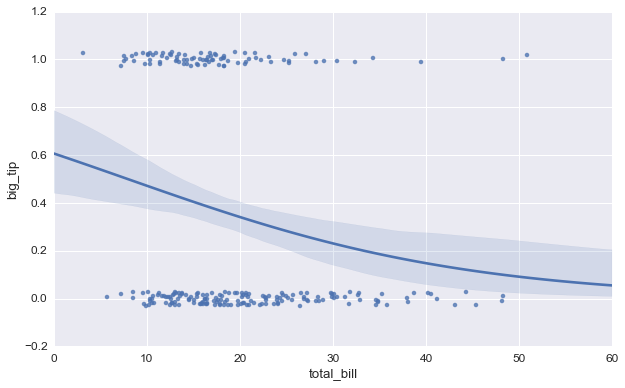

In [4]:
# Seaborn regplot (logistic=True) <= uses GLM from statsmodels under the hood
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='total_bill', y='big_tip', data=tips, logistic=True, n_boot=500, y_jitter=.03, ax=ax)
plt.show()

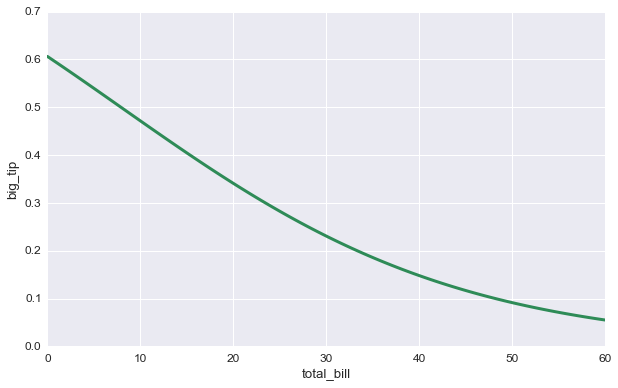

In [5]:
# Extract the line data from the seaborn figure
xs, ys = ax.get_lines()[0].get_data()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(xs, ys, ls='-', c='seagreen', lw=3)
ax.set_xlabel('total_bill')
ax.set_ylabel('big_tip')
plt.show()

#### Create endog and exog variables for further usage in satsmodels and scikit-learn routines

In [6]:
X = np.c_[np.ones(tips.shape[0]), tips['total_bill']]
y = tips['big_tip']

### Statsmodels GLM function
Statsmodels GLM: http://statsmodels.sourceforge.net/stable/glm.html

In [7]:
# Statsmodels Logistic Regression using GLM with Binomial family and Logit (default) link
model_sm = sm.GLM(y, X, family=sm.families.Binomial())    # notice the order of the endog and exog variables
res_sm = model_sm.fit()
res_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                big_tip   No. Observations:                  244
Model:                            GLM   Df Residuals:                      242
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -152.96
Date:                Tue, 10 Nov 2015   Deviance:                       305.92
Time:                        08:41:50   Pearson chi2:                     250.
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4322      0.354      1.222      0.222        -0.261     1.126
x1            -0.0546      0.018     -3.066      0.002        -0.089    -0.020
==============================================================================
"""

#### Create new data for the prediction

In [8]:
# New data for the prediction
support = np.linspace(0, 60, 100)
xnew = np.c_[np.ones(support.size), support]  # must be a 2D array

In [9]:
out_sm = res_sm.predict(xnew)

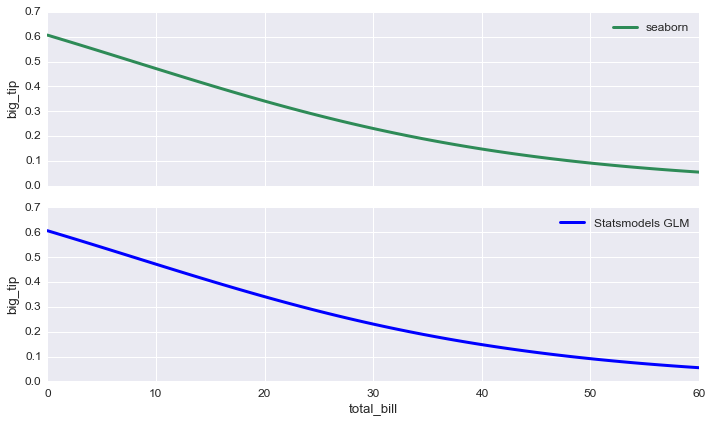

In [10]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,6))
ax[0].plot(xs, ys, ls='-', c='seagreen', lw=3, label='seaborn')
ax[0].set_ylabel('big_tip')
ax[0].legend(loc='best')
ax[1].plot(support, out_sm, ls='-', c='blue', lw=3, label='Statsmodels GLM')
ax[1].set_xlabel('total_bill')
ax[1].set_ylabel('big_tip')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [11]:
# Difference between curves
diff = np.sum(abs(ys-out_sm))
print('Total difference: {:g}'.format(diff))

Total difference: 0


#### Bootstrap confidence intervals for the coefficients of logistic regression
Bootstrap wiki: https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29

In [12]:
# yhat values
yhat = res_sm.fittedvalues
# residuals
resid = res_sm.resid_response

alpha = 0.05   # 95% confidence interval
n_boot = 1000  # No. of bootstrap samples

const = []; x1 = []
const.append(res_sm.params[0])  # constant term
x1.append(res_sm.params[1])     # x1 value

# Bootstrap
for i in range(n_boot):
    resid_boot = np.random.choice(resid, size=len(resid), replace=True)
    yboot = yhat + resid_boot
    model_boot = sm.GLM(yboot, X, family=sm.families.Binomial())
    res_boot = model_boot.fit()
    const.append(res_boot.params[0])
    x1.append(res_boot.params[1])

# Confidence intervals
def ci(var):
    coef = np.asarray(var)
    c_mean = np.mean(coef)
    c_std = np.std(coef)
    ql = (alpha/2)*100.
    qh = (1 - alpha/2)*100.
    ci_low = np.percentile(coef, ql, interpolation='midpoint')
    ci_high = np.percentile(coef, qh, interpolation='midpoint')
    return c_mean, c_std, ci_low, ci_high

# Const
cm, cs, cl, ch = ci(const)
# Coeff
x1m, x1s, x1l, x1h = ci(x1)

print('Coefficiens of the logistic regression (compare with output from GLM above):')
print('Const: Mean value: {:7.4f}, Std. error: {:7.4f}, 95% Conf. Int.: {:7.4f} to {:7.4f}'.format(cm, cs, cl, ch))
print('x1:    Mean value: {:7.4f}, Std. error: {:7.4f}, 95% Conf. Int.: {:7.4f} to {:7.4f}'.format(x1m, x1s, x1l, x1h))

Coefficiens of the logistic regression (compare with output from GLM above):
Const: Mean value:  0.4680, Std. error:  0.3884, 95% Conf. Int.: -0.2302 to  1.2916
x1:    Mean value: -0.0569, Std. error:  0.0216, 95% Conf. Int.: -0.1043 to -0.0191


### Statsmodels Logit function
Statsmodels Logit: http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html

In [13]:
# Statsmodels Logit function
model_logit = sm.Logit(y, X)  # notice the order of the endog and exog variables
res_logit = model_logit.fit()

Optimization terminated successfully.
         Current function value: 0.626881
         Iterations 5


In [14]:
res_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                big_tip   No. Observations:                  244
Model:                          Logit   Df Residuals:                      242
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Nov 2015   Pseudo R-squ.:                 0.03402
Time:                        08:41:55   Log-Likelihood:                -152.96
converged:                       True   LL-Null:                       -158.35
                                        LLR p-value:                  0.001030
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4322      0.354      1.222      0.222        -0.261     1.126
x1            -0.0546      0.018     -3.066      0.002        -0.089    -0.020
==============================================================================
"""

In [15]:
out_logit = res_logit.predict(xnew)

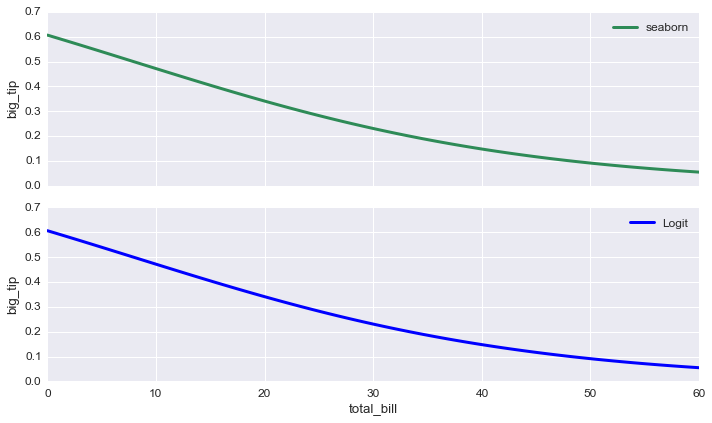

In [16]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,6))
ax[0].plot(xs, ys, ls='-', c='seagreen', lw=3, label='seaborn')
ax[0].set_ylabel('big_tip')
ax[0].legend(loc='best')
ax[1].plot(support, out_logit, ls='-', c='blue', lw=3, label='Logit')
ax[1].set_xlabel('total_bill')
ax[1].set_ylabel('big_tip')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [17]:
# Difference between curves
diff = np.sum(abs(ys-out_logit))
print('Total difference: {:g}'.format(diff))

Total difference: 1.48284e-14


### Scikit-learn LogisticRegression function
Scikit-learn LogisticRegression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [18]:
# Scikit-learn Logistic Regression
model_sk = LogisticRegression(C=1e6, fit_intercept=False)  # constant term is already in exog
res_sk = model_sk.fit(X, y)  # notice the order of the endog and exog variables
res_sk.coef_

array([[ 0.43223329, -0.05456015]])

In [19]:
out_sk = res_sk.predict_proba(xnew)  # returns a 2D array; second column is important

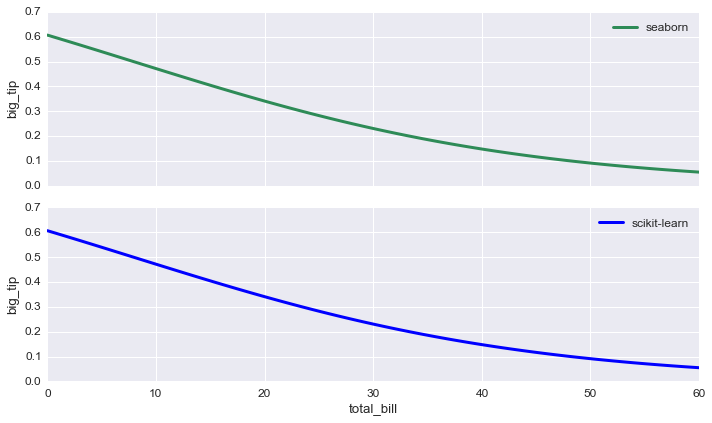

In [20]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,6))
ax[0].plot(xs, ys, ls='-', c='seagreen', lw=3, label='seaborn')
ax[0].set_ylabel('big_tip')
ax[0].legend(loc='best')
ax[1].plot(support, out_sk[:,1], ls='-', c='blue', lw=3, label='scikit-learn')
ax[1].set_xlabel('total_bill')
ax[1].set_ylabel('big_tip')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [21]:
# Difference between curves
diff = np.sum(abs(ys-out_sk[:,1]))
print('Total difference: {:g}'.format(diff))

Total difference: 3.90914e-05


### Bootstrap the confidence interval on predicted values
Demonstrate using bootstrap to compute the confidence interval on predicted values. Logistic regression using GLM from statsmodels.

In [22]:
alpha = 0.05  # 95% confidence interval
n_boot = 1000  # No. of bootstrap samples

y_hat = res_sm.fittedvalues  # fittedvalues = np.dot(exog, params)
residuals = res_sm.resid_response  # residuals = endog - fittedvalues

values = []
# Bootstrap
for i in range(n_boot):
    resid_boot = np.random.choice(residuals, size=len(residuals), replace=True)
    yboot = y_hat + resid_boot
    model_boot = sm.GLM(yboot, X, family=sm.families.Binomial())
    res_boot = model_boot.fit()
    # Prediction values
    out_boot = res_boot.predict(xnew)
    values.append(out_boot)
values = np.asarray(values)

# Means and standard deviations of predicted values
means = np.mean(values, axis=0)
stds = np.std(values, axis=0)

ql = (alpha/2)*100.
qh = (1 - alpha/2)*100.
ci_lows = np.percentile(values, ql, axis=0, interpolation='midpoint')
ci_higs = np.percentile(values, qh, axis=0, interpolation='midpoint')

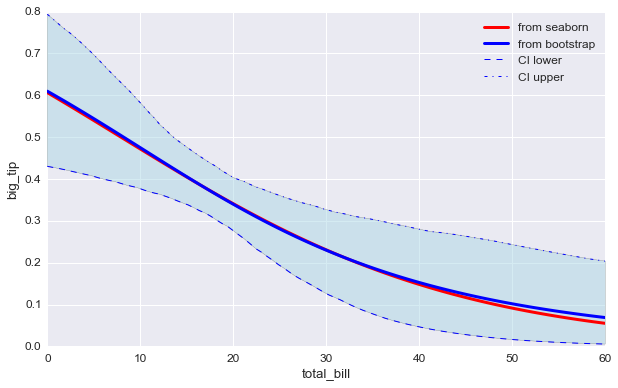

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(xs, ys, ls='-', c='red', lw=3, label='from seaborn')
ax.plot(support, means, c='blue', ls='-', lw=3, label='from bootstrap')
ax.plot(support, ci_lows, c='blue', ls='--', lw=1, label='CI lower')
ax.plot(support, ci_higs, c='blue', ls='-.', lw=1, label='CI upper')
ax.fill_between(support, ci_lows, ci_higs, facecolor='lightblue', interpolate=True, alpha=0.5)
ax.legend(loc='best')
ax.set_xlabel('total_bill')
ax.set_ylabel('big_tip')
plt.show()

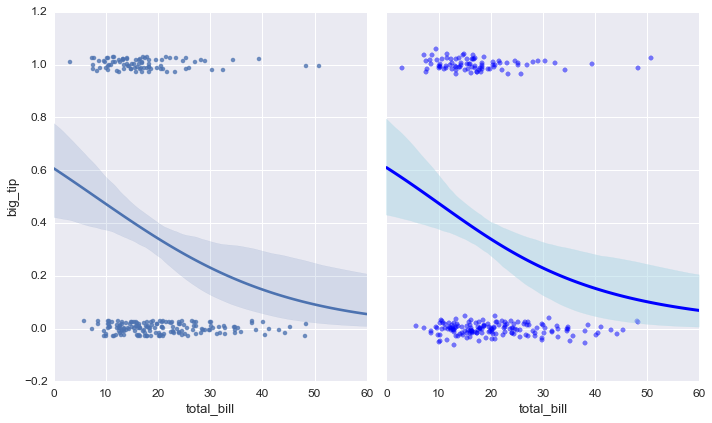

In [24]:
# Jitter data in scatter plot
def jitter(arr, size=0.01):
    stdev = size*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# Comparing bootstrap confidence intervals with seaborn
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,6))
sns.regplot(x='total_bill', y='big_tip', data=tips, logistic=True, n_boot=500, y_jitter=.03, ax=ax[0])
ax[1].scatter(tips['total_bill'], jitter(tips['big_tip'], size=0.02), color='blue', alpha=0.5)
ax[1].plot(support, means, c='blue', ls='-', lw=3)
ax[1].fill_between(support, ci_lows, ci_higs, facecolor='lightblue', edgecolor='lightblue', interpolate=True, alpha=0.5)
ax[1].set_xlabel('total_bill')
ax[1].set_xlim(0,60)
plt.tight_layout()
plt.show()

## Linear Regression
### Seaborn regplot function
Seaborn regplot: https://web.stanford.edu/~mwaskom/software/seaborn/generated/seaborn.regplot.html#seaborn.regplot

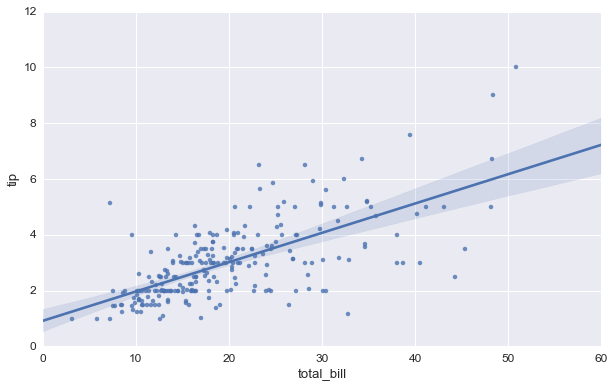

In [25]:
# Seaborn regplot 
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='total_bill', y='tip', data=tips, ax=ax)
plt.show()

In [26]:
# Extract the line data from the seaborn figure
xs, ys = ax.get_lines()[0].get_data()

#### Create endog and exog variables for further usage in satsmodels and scikit-learn routines

In [27]:
X = np.c_[np.ones(tips.shape[0]), tips['total_bill']]
y = tips['tip']

### Statsmodels OLS function
Statsmodels OLS: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS

In [28]:
# Statsmodels Linear Regression using OLS 
model_ols = sm.OLS(y, X)    # notice the order of the endog and exog variables
res_ols = model_ols.fit()
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     203.4
Date:                Tue, 10 Nov 2015   Prob (F-statistic):           6.69e-34
Time:                        08:42:03   Log-Likelihood:                -350.54
No. Observations:                 244   AIC:                             705.1
Df Residuals:                     242   BIC:                             712.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.9203      0.160      5.761      0.000         0.606     1.235
x1             0.1050      0.007     14.260      0.000         0.091     0.120
==============================================================================
Omnibus:                       20.185   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.750
Skew:                           0.443   Prob(JB):                     6.35e-09
Kurtosis:                       4.711   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# New data for the prediction
support = np.linspace(0, 60, 100)
xnew = np.c_[np.ones(support.size), support]  # must be a 2D array

In [30]:
out_ols = res_ols.predict(xnew)

In [31]:
# Difference between curves
diff = np.sum(abs(ys-out_ols))
print('Total difference: {:g}'.format(diff))

Total difference: 0


### Bootstrap the confidence interval on predicted values
Bootstrap wiki: https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29

Demonstrate using bootstrap to compute the confidence interval on predicted values. Linear regression using OLS from statsmodels.

In [32]:
alpha = 0.05  # 95% confidence interval
n_boot = 1000  # No. of bootstrap samples

y_hat = res_ols.fittedvalues  # fittedvalues = np.dot(exog, params)
residuals = res_ols.resid  # residuals = endog - fittedvalues

values = []
# Bootstrap
for i in range(n_boot):
    resid_boot = np.random.choice(residuals, size=len(residuals), replace=True)
    yboot = y_hat + resid_boot
    model_boot = sm.OLS(yboot, X)
    res_boot = model_boot.fit()
    # Prediction values
    out_boot = res_boot.predict(xnew)
    values.append(out_boot)
values = np.asarray(values)

# Means and standard deviations of predicted values
means = np.mean(values, axis=0)
stds = np.std(values, axis=0)

ql = (alpha/2)*100.
qh = (1 - alpha/2)*100.
ci_lows = np.percentile(values, ql, axis=0, interpolation='midpoint')
ci_higs = np.percentile(values, qh, axis=0, interpolation='midpoint')

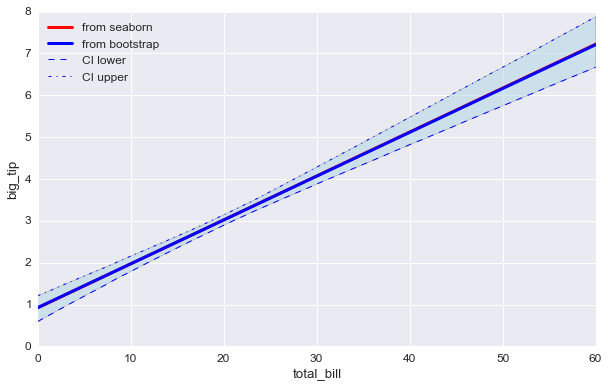

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(xs, ys, ls='-', c='red', lw=3, label='from seaborn')
ax.plot(support, means, c='blue', ls='-', lw=3, label='from bootstrap')
ax.plot(support, ci_lows, c='blue', ls='--', lw=1, label='CI lower')
ax.plot(support, ci_higs, c='blue', ls='-.', lw=1, label='CI upper')
ax.fill_between(support, ci_lows, ci_higs, facecolor='lightblue', interpolate=True, alpha=0.5)
ax.legend(loc='best')
ax.set_xlabel('total_bill')
ax.set_ylabel('big_tip')
plt.show()

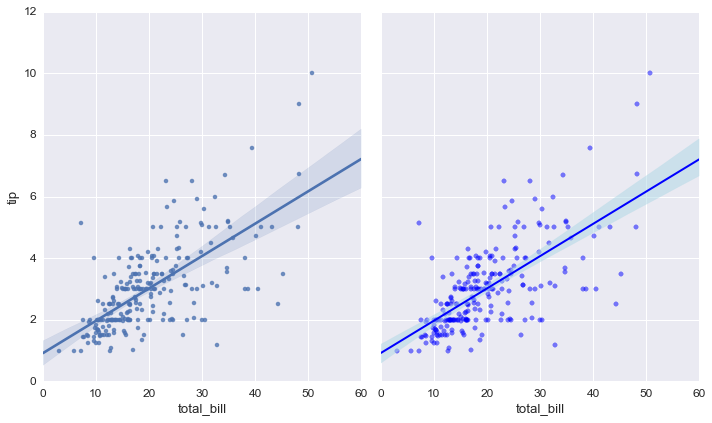

In [34]:
# Comparing bootstrap confidence intervals with seaborn
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,6))
sns.regplot(x='total_bill', y='tip', data=tips, ax=ax[0])
ax[1].scatter(tips['total_bill'], tips['tip'], color='blue', alpha=0.5)
ax[1].plot(support, means, c='blue', ls='-', lw=2)
ax[1].fill_between(support, ci_lows, ci_higs, facecolor='lightblue', edgecolor='lightblue', interpolate=True, alpha=0.5)
ax[1].set_xlabel('total_bill')
ax[1].set_xlim(0,60)
plt.tight_layout()
plt.show()

### Prediction intervals for linear regression
Ordinary Least Squares: http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html

In [35]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Computing prediction intervals from OLS regression
prstd, iv_l, iv_u = wls_prediction_std(res_ols, exog=xnew, alpha=0.05)  # notice the exog parameter

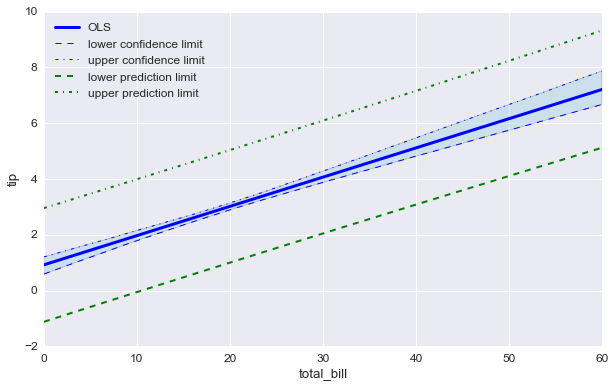

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(support, means, c='blue', ls='-', lw=3, label='OLS')
ax.plot(support, ci_lows, c='blue', ls='--', lw=1, label='lower confidence limit')
ax.plot(support, ci_higs, c='blue', ls='-.', lw=1, label='upper confidence limit')
ax.fill_between(support, ci_lows, ci_higs, facecolor='lightblue', interpolate=True, alpha=0.5)
ax.plot(support, iv_l, c='green', ls='--', lw=2, label='lower prediction limit')
ax.plot(support, iv_u, c='green', ls='-.', lw=2, label='upper prediction limit')
ax.legend(loc='best')
ax.set_xlabel('total_bill')
ax.set_ylabel('tip')
plt.show()

### Scikit-learn LinearRegression function
Scikit-learn LinearRegression: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [37]:
# Scikit-learn Linear Regression
model_skl = LinearRegression(fit_intercept=False)  # constant term is already in exog
res_skl = model_skl.fit(X, y)  # notice the order of the endog and exog variables

In [38]:
out_skl = res_skl.predict(xnew)  

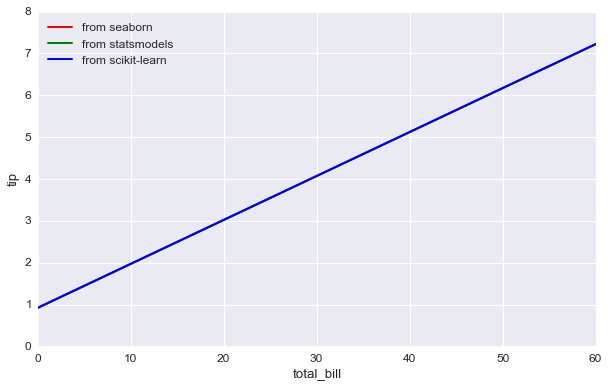

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(xs, ys, ls='-', c='red', lw=2, label='from seaborn')
ax.plot(support, out_ols, c='green', ls='-', lw=2, label='from statsmodels')
ax.plot(support, out_skl, c='blue', ls='-', lw=2, label='from scikit-learn')
ax.legend(loc='best')
ax.set_xlabel('total_bill')
ax.set_ylabel('tip')
plt.show()

In [40]:
# Difference between curves (seaborn vs scikit-learn)
diff = np.sum(abs(ys-out_skl))
print('Total difference: {:g}'.format(diff))

Total difference: 4.19664e-14


### Alternative way of computing confidence and prediction intervals for linear regression
Stackoverflow: https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels

In [41]:
from statsmodels.stats.outliers_influence import summary_table

# Simple example
x = np.linspace(0, 10, 100)
e = np.random.normal(size=100)
y = 1 + 0.5*x + 2*e
X = sm.add_constant(x)

# OLS model
re = sm.OLS(y, X).fit()

# Summary table
st, data, ss2 = summary_table(re, alpha=0.05)

print(ss2)  # column names 

# Fitted values
fittedvalues = data[:,2]  
# Confidence interval
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
# Prediction interval
predict_ci_low, predict_ci_upp = data[:,6:8].T

['Obs', 'Dep Var\nPopulation', 'Predicted\nValue', 'Std Error\nMean Predict', 'Mean ci\n95% low', 'Mean ci\n95% upp', 'Predict ci\n95% low', 'Predict ci\n95% upp', 'Residual', 'Std Error\nResidual', 'Student\nResidual', "Cook's\nD"]


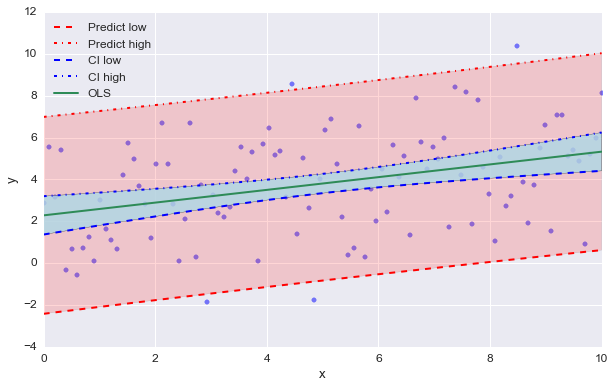

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
# Scatter
ax.scatter(x, y, color='blue', alpha=0.5)
# Confidence interval
ax.plot(x, predict_ci_low, c='red', ls='--', lw=2, label='Predict low')
ax.plot(x, predict_ci_upp, c='red', ls='-.', lw=2, label='Predict high')
ax.fill_between(x, predict_ci_low, predict_ci_upp, facecolor='#FF3333', interpolate=True, alpha=0.2)
# Predicition interval
ax.plot(x, predict_mean_ci_low, c='blue', ls='--', lw=2, label='CI low')
ax.plot(x, predict_mean_ci_upp, c='blue', ls='-.', lw=2, label='CI high')
ax.fill_between(x, predict_mean_ci_low, predict_mean_ci_upp, facecolor='lightblue', interpolate=True, alpha=0.8)
# OLS regression line
ax.plot(x, fittedvalues, c='seagreen', ls='-', lw=2, label='OLS')
ax.legend(loc='best')
ax.set_xlim(0, 10)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

### Classical statistical view of the confidence and prediction intervals for linear regression

For the linear model:

$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$

the $100(1-\alpha)$ % confidence intervals for $\beta_0$ and $\beta_1$ are given by:

$\hat \beta_0 \pm t_{n-2,\alpha/2} \cdot s_{\beta_0}$

$\hat \beta_1 \pm t_{n-2,\alpha/2} \cdot s_{\beta_1}$

with:

$s_{\hat \beta_0} = s \cdot \sqrt{{1\over n} + {\bar x^2 \over \sum_{i=1}^n{(x_i-\bar x)^2}}}$

$s_{\hat \beta_1} = {s \over \sqrt{\sum_{i=1}^n{(x_i-\bar x)^2}}}$

$s = \sqrt{{(1-r^2)\sum_{i=1}^n{(y_i-\bar y)^2}}\over{n-2}}$

where: 

n - number of samples; 

$\bar x$, $\bar y$ - mean values of x and y, respectively

r - coefficient of correlation between x and y

$t_{n-2,\alpha/2}$ - point on the Student's t curve with n-2 degrees of freedom that cuts the area of $\alpha/2$ in the right-hand tail. 

This means that the confidence intervals for $\beta_0$ and $\beta_1$ can be derived in exactly the same way as the Student's t based confidence interval for a population mean.

#### Confidence interval

A level $100(1-\alpha)$ % confidence interval for the quantity $\beta_0 + \beta_1 x$ is given by:

$\hat \beta_0 + \hat \beta_1 x \pm t_{n-2,\alpha/2} \cdot s_{\hat y}$

where:

$s_{\hat y} = s \cdot \sqrt{{1\over n} + {(x-\bar x)^2 \over \sum_{i=1}^n{(x_i-\bar x)^2}}}$

#### Prediction interval

A level $100(1-\alpha)$ % prediction interval for the quantity $\beta_0 + \beta_1 x$ is given by:

$\hat \beta_0 + \hat \beta_1 x \pm t_{n-2,\alpha/2} \cdot s_{pred}$

where:

$s_{pred} = s \cdot \sqrt{1 + {1\over n} + {(x-\bar x)^2 \over \sum_{i=1}^n{(x_i-\bar x)^2}}}$